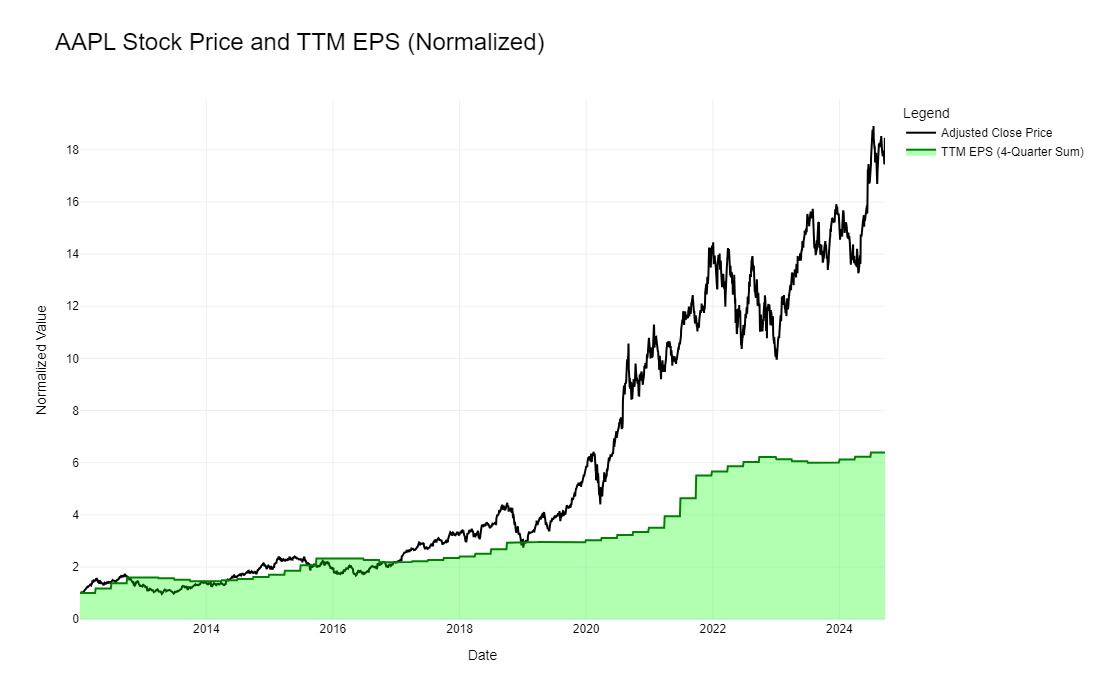

In [4]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load stock data
stock_data_file = 'data/AAPL_EOD_2012-01-01_to_2024-09-21.csv'  # Update the path as needed
stock_df = pd.read_csv(stock_data_file)
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df = stock_df.sort_values('date')

# Use 'adjClose' for adjusted stock prices
stock_df['adjusted_close'] = stock_df['adjClose']

# Calculate cumulative split factor from the stock data
stock_df['cumulative_split'] = stock_df['splitFactor'].cumprod()

# Load EPS data
eps_data_file = 'fundamentals/aapl-0000320193-EPS.csv'
eps_df = pd.read_csv(eps_data_file)
eps_df['date'] = pd.to_datetime(eps_df['date'])
eps_df = eps_df.sort_values('date')

# Merge cumulative split factor into EPS data
eps_df = pd.merge_asof(eps_df, stock_df[['date', 'cumulative_split']], on='date', direction='forward')

# Fill missing 'cumulative_split' values with 1 (no split)
eps_df['cumulative_split'] = eps_df['cumulative_split'].fillna(1)

# Adjust EPS for splits by multiplying
eps_df['adj_EarningsPerShareDiluted'] = eps_df['EarningsPerShareDiluted'] * eps_df['cumulative_split']

# Compute TTM EPS (rolling sum of last 4 quarters of adjusted EPS)
eps_df['TTM_EPS'] = eps_df['adj_EarningsPerShareDiluted'].rolling(window=4).sum()

# Merge TTM EPS into stock data
stock_df = pd.merge_asof(stock_df, eps_df[['date', 'TTM_EPS']], on='date', direction='backward')
stock_df = stock_df.dropna(subset=['TTM_EPS'])

# Normalize data to start at the same point
start_date = stock_df['date'].iloc[0]
initial_price = stock_df.loc[stock_df['date'] == start_date, 'adjusted_close'].values[0]
initial_ttm_eps = stock_df.loc[stock_df['date'] == start_date, 'TTM_EPS'].values[0]

stock_df['normalized_price'] = stock_df['adjusted_close'] / initial_price
stock_df['normalized_ttm_eps'] = stock_df['TTM_EPS'] / initial_ttm_eps

# Create the plot
fig = go.Figure()

# Plot normalized adjusted close price as black line
fig.add_trace(
    go.Scatter(
        x=stock_df['date'],
        y=stock_df['normalized_price'],
        name='Adjusted Close Price',
        mode='lines',
        line=dict(color='black')
    )
)

# Plot normalized TTM EPS as green area with transparency
fig.add_trace(
    go.Scatter(
        x=stock_df['date'],
        y=stock_df['normalized_ttm_eps'],
        name='TTM EPS (4-Quarter Sum)',
        mode='lines',
        line=dict(color='green'),
        fill='tozeroy',
        fillcolor='rgba(0, 255, 0, 0.3)'  # Green with 30% opacity
    )
)

# Update layout
fig.update_layout(
    title='AAPL Stock Price and TTM EPS (Normalized)',
    xaxis_title='Date',
    yaxis_title='Normalized Value',
    legend_title='Legend',
    template='plotly_white',
    width=1200,
    height=700,
    font=dict(
        family='Arial, sans-serif',
        size=12,
        color='black'
    ),
    title_font=dict(
        size=24,
        color='black'
    )
)

# Show the figure
fig.show()
